In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
import datetime
import pickle
import shapely
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import Polygon
import pprint
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
import seaborn as sns

In [2]:
promise_zone = gpd.read_file('../data/MDHA_Promise_Zones/Export_Output_5.shp')

In [3]:
promise_zone = promise_zone.to_crs('EPSG:4326')

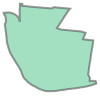

In [4]:
promise_zone.loc[0, 'geometry']

In [5]:
may_trips = pd.read_csv('../data/may_trip.csv')

In [6]:
june_trips = pd.read_csv('../data/june_trip.csv')

In [7]:
july_trips = pd.read_csv('../data/july_trip.csv')

In [8]:
comb_trips = pd.concat([may_trips,june_trips,july_trips], ignore_index=True)

In [9]:
comb_trips.tail(1)

,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,startLatitude,startLongitude,endLatitude,endLongitude,tripRoute,create_dt
565521,2019-08-01 07:04:00,JUMP,JMP34,Powered784fcc92-bd1a-5f6a-8314-b02aa21b4bfa,209.40965,14889.6,2019-07-31 00:00:00,22:19:08,2019-08-01 00:00:00,01:48:33,36.16005,-86.77672,36.16341,-86.7821,"[[""36.160051"",""-86.77672""],[""36.160051"",""-86.7...",2019-08-02 08:24:22


In [10]:
comb_trips['pubTimeStamp'] = pd.to_datetime(comb_trips['pubTimeStamp'])

In [11]:
comb_trips['geometry'] = comb_trips.apply(lambda x: Point((x.startLongitude,x.startLatitude)),
                                        axis=1)

In [12]:
comb_trips['day'] = pd.to_datetime(comb_trips['startDate'])


In [13]:
scooter_geo = gpd.GeoDataFrame(comb_trips,crs=promise_zone.crs,geometry=comb_trips.geometry)

In [14]:
scooter_geo = scooter_geo.drop(columns = 'create_dt')

In [15]:
scooter_geo['day'] = scooter_geo['day'].dt.day


In [16]:
scooter_geo.tail(1)

,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,startLatitude,startLongitude,endLatitude,endLongitude,tripRoute,geometry,day
565521,2019-08-01 07:04:00,JUMP,JMP34,Powered784fcc92-bd1a-5f6a-8314-b02aa21b4bfa,209.40965,14889.6,2019-07-31 00:00:00,22:19:08,2019-08-01 00:00:00,01:48:33,36.16005,-86.77672,36.16341,-86.7821,"[[""36.160051"",""-86.77672""],[""36.160051"",""-86.7...",POINT (-86.77672 36.16005),31


In [17]:
scooters_promise_zone = gpd.sjoin( scooter_geo,promise_zone, op = 'within')

In [18]:
scooters_promise_zone = scooters_promise_zone.drop(columns = 'index_right')

In [19]:
# total area for the grid
xmin, ymin, xmax, ymax= scooters_promise_zone.total_bounds
# how many cells across and down
n_cells=50
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = promise_zone.crs
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)

(-86.892124693, -86.685807967, 36.072959913999995, 36.242867806000056)

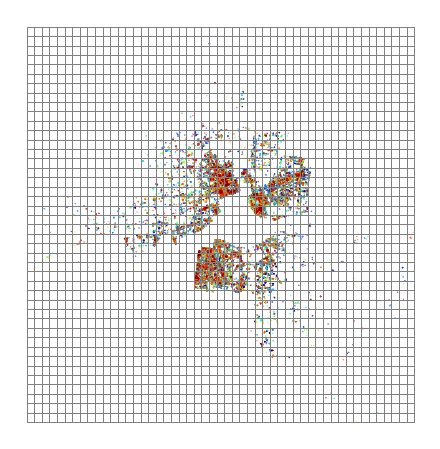

In [20]:
ax = scooters_promise_zone.plot(markersize=.1, figsize=(12, 8), column='day', cmap='jet')
cell.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off")

In [21]:
merged = gpd.sjoin(scooters_promise_zone, cell, how='left', op='within')

In [22]:
merged.tail()

,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,...,endLatitude,endLongitude,tripRoute,geometry,day,OBJECTID,ZONE_ID,SHAPE_STAr,SHAPE_STLe,index_right
550898,2019-07-28 02:01:46.340,Bird,BRD6344,PoweredUAM6D,12.00000,0.00000,2019-07-28 00:00:00,01:50:46.113333,2019-07-28 00:00:00,02:02:39.276666,...,36.15810,-86.84930,"[[36.158168,-86.839818],[36.158159,-86.839827]...",POINT (-86.83990 36.15810),28,6,6,9.535996e+07,59256.923574,483.0
550919,2019-07-28 02:01:46.340,Bird,BRD6342,PoweredFJ6GU,9.00000,1312.33600,2019-07-28 00:00:00,01:52:38.756666,2019-07-28 00:00:00,02:01:47.696666,...,36.15790,-86.84100,"[[36.150274,-86.858029],[36.150193,-86.858082]...",POINT (-86.85820 36.15010),28,6,6,9.535996e+07,59256.923574,270.0
553970,2019-07-28 20:59:47.030,Lyft,LFT888,Powered210350,8.44755,8182.41496,2019-07-28 00:00:00,20:51:20.063333,2019-07-28 00:00:00,20:59:46.916666,...,36.14427,-86.84059,"[[36.16046,-86.84923],[36.16041,-86.84913],[36...",POINT (-86.84923 36.16046),28,6,6,9.535996e+07,59256.923574,399.0
558375,2019-07-29 21:53:21.157,Bird,BRD1601,PoweredH5738,6.00000,0.00000,2019-07-29 00:00:00,21:48:58.693333,2019-07-29 00:00:00,21:55:11.310000,...,36.15630,-86.85270,"[[36.168404,-86.862658],[36.168311,-86.862687]...",POINT (-86.86270 36.16850),29,6,6,9.535996e+07,59256.923574,233.0
558977,2019-07-29 23:33:24.767,Bird,BRD1961,PoweredH5738,7.00000,0.00000,2019-07-29 00:00:00,23:27:23.090000,2019-07-29 00:00:00,23:34:03.176666,...,36.16480,-86.86330,"[[36.156365,-86.852606],[36.156286,-86.852523]...",POINT (-86.85260 36.15630),29,6,6,9.535996e+07,59256.923574,356.0


In [23]:
promise_zone.geometry.centroid

C:\Users\RMAUR\AppData\Local\Temp/ipykernel_3448/588962931.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  promise_zone.geometry.centroid


0    POINT (-86.76416 36.17641)
1    POINT (-86.77976 36.13860)
2    POINT (-86.72581 36.14281)
3    POINT (-86.74062 36.10276)
4    POINT (-86.80486 36.18972)
5    POINT (-86.86377 36.15331)
dtype: geometry

In [24]:
center = promise_zone.geometry.centroid[4]
print(center)

POINT (-86.80486005128736 36.18972152401118)


C:\Users\RMAUR\AppData\Local\Temp/ipykernel_3448/1354181034.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = promise_zone.geometry.centroid[4]


In [25]:
# reverse the order when constructing the array for folium location
area_center = [center.y, center.x]

# check the order of area_center, the location for our folium map
print(area_center)

[36.18972152401118, -86.80486005128736]


In [26]:
#draw our zip code area: 37207

style1 = { 'color': '#808080','opacity':.5}
style2 = {'fillColor': '#00FFFFFF', 'color': '#00FFFFFF'}

promise_zone_map = folium.Map(location =  area_center, zoom_start = 12)

folium.GeoJson(promise_zone).add_to(promise_zone_map)

folium.GeoJson(cell,name='district_cells',style_function=lambda x:style1).add_to(promise_zone_map)

#display our map
promise_zone_map


In [27]:
merged = merged.sort_values('index_right')

In [30]:
dissolve = merged.drop(['companyName','tripRecordNum','startTime','endDate','endTime','endLatitude','endLongitude'],axis=1)

In [31]:
dissolve = dissolve.drop(columns = 'day')

In [32]:
grouped = dissolve.set_index('index_right')

In [33]:
grouped =grouped.dissolve(by="index_right", aggfunc="mean")

In [35]:
grouped['tripDuration'] = grouped.tripDuration.round(3)

In [37]:
grouped['tripDistance'] = grouped.tripDistance.round(3)

In [38]:
grouped['center'] = grouped.geometry.centroid

C:\Users\RMAUR\AppData\Local\Temp/ipykernel_3448/2524323961.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grouped['center'] = grouped.geometry.centroid


In [185]:
grouped.head()

,geometry,tripDuration,tripDistance,startLatitude,startLongitude,OBJECTID,ZONE_ID,SHAPE_STAr,SHAPE_STLe,center
index_right,,,,,,,,,,
58.0,POINT (-86.87853 36.14093),4.333,3005.213,36.140926,-86.878533,6.0,6.0,9.535996e+07,59256.923574,POINT (-86.87853 36.14093)
101.0,"MULTIPOINT (-86.87276 36.14505, -86.87212 36.1...",25.101,111.531,36.145051,-86.872591,6.0,6.0,9.535996e+07,59256.923574,POINT (-86.87225 36.14506)
104.0,POINT (-86.87353 36.15765),9.650,9091.097,36.157648,-86.873529,6.0,6.0,9.535996e+07,59256.923574,POINT (-86.87353 36.15765)
105.0,POINT (-86.87472 36.15936),9.017,0.000,36.159361,-86.874722,6.0,6.0,9.535996e+07,59256.923574,POINT (-86.87472 36.15936)
106.0,"MULTIPOINT (-86.87433 36.16410, -86.87397 36.1...",9.375,5537.990,36.163983,-86.874150,6.0,6.0,9.535996e+07,59256.923574,POINT (-86.87415 36.16398)


In [303]:
#draw our zip code area: 37207

style1 = { 'color': '#808080','opacity':.5}
style2 = {'fillColor': '#00FFFFFF', 'color': '#00FFFFFF'}

promise_zone_map = folium.Map(location =  area_center, zoom_start = 12,tooltip = 'This tooltip will appear on hover')

folium.GeoJson(promise_zone).add_to(promise_zone_map)

folium.GeoJson(cell,name='district_cells',style_function=lambda x:style1).add_to(promise_zone_map)

for row_index, row_values in grouped.iterrows():
    loc = [row_values['startLatitude'], row_values['startLongitude']]
    pop1 = str(row_values['tripDuration'])
    pop2 = str(row_values['tripDistance'])
    
    
    marker = folium.CircleMarker(
        location = loc, 
        opacity = .0,
        tooltip = 'avg trip duration: ' + pop1 + '\n' +
        'avg trip distance: ' + pop2)

        
    marker.add_to(promise_zone_map)
promise_zone_map.save('../maps/promise_zone_map.html')

#display our map
promise_zone_map


In [43]:
merged.head()

,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,...,endLatitude,endLongitude,tripRoute,geometry,day,OBJECTID,ZONE_ID,SHAPE_STAr,SHAPE_STLe,index_right
344684,2019-06-16 00:52:40.293,Lime,LIM141,PoweredSDQ6GAHIJK5AF,4.333333,3005.2128,2019-06-16 00:00:00,00:32:28,2019-06-16 00:00:00,00:36:48,...,36.135753,-86.889040,"[[36.13889,-86.88084],[36.13653,-86.8839000000...",POINT (-86.87853 36.14093),16,6,6,9.535996e+07,59256.923574,58.0
108731,2019-05-18 00:07:29.623,Lime,LIM26,PoweredNJHY4U3JH3M7W,32.000000,88.0872,2019-05-17 00:00:00,23:31:46,2019-05-18 00:00:00,00:03:46,...,36.145409,-86.871928,"[[36.14503,-86.87279],[36.14489,-86.8732699999...",POINT (-86.87276 36.14505),17,6,6,9.535996e+07,59256.923574,101.0
112189,2019-05-18 08:53:10.463,Lime,LIM197,PoweredNJHY4U3JH3M7W,32.000000,88.0872,2019-05-17 00:00:00,23:31:46,2019-05-18 00:00:00,00:03:46,...,36.145409,-86.871928,"[[36.14503,-86.87279],[36.14489,-86.8732699999...",POINT (-86.87276 36.14505),17,6,6,9.535996e+07,59256.923574,101.0
141117,2019-05-21 22:48:59.287,Lime,LIM1984,PoweredNJHY4U3JH3M7W,4.816667,384.9624,2019-05-21 00:00:00,21:47:41,2019-05-21 00:00:00,21:52:30,...,36.141376,-86.881873,"[[36.14507,-86.87212],[36.145019999999995,-86....",POINT (-86.87212 36.14507),21,6,6,9.535996e+07,59256.923574,101.0
112314,2019-05-18 09:38:13.790,Lime,LIM200,PoweredNJHY4U3JH3M7W,32.000000,88.0872,2019-05-17 00:00:00,23:31:46,2019-05-18 00:00:00,00:03:46,...,36.145409,-86.871928,"[[36.14503,-86.87279],[36.14489,-86.8732699999...",POINT (-86.87276 36.14505),17,6,6,9.535996e+07,59256.923574,101.0


In [97]:
corr = merged[['tripDuration','tripDistance','geometry','index_right','endLatitude','endLongitude']].copy()

In [98]:
corr = corr.reset_index()

In [99]:
corr = corr.drop(columns = 'index')

In [209]:
ryman_coords.head()

,tripDuration,tripDistance,geometry,index_right,endLatitude,endLongitude,lat_lng_concat,long_lat,lat_long
113089,10.633333,3005.2128,POINT (-86.72336 36.08068),NaN,36.16205,-86.774199,-50.612149,"(36.16205, -86.774199)","(36.16205, -86.774199)"


In [142]:
corr = corr.drop(['lat_lng_concat','long_lat','lat_long'],axis = 1)

In [198]:
downtown_center = grouped.iloc[1].center

In [199]:
corr.head()

,tripDuration,tripDistance,geometry,index_right,endLatitude,endLongitude,dist_from_1st
0,4.333333,3005.2128,POINT (-86.87853 36.14093),58.0,36.135753,-86.889040,0.166456
1,32.000000,88.0872,POINT (-86.87276 36.14505),101.0,36.145409,-86.871928,0.162675
2,32.000000,88.0872,POINT (-86.87276 36.14505),101.0,36.145409,-86.871928,0.162675
3,4.816667,384.9624,POINT (-86.87212 36.14507),101.0,36.141376,-86.881873,0.162100
4,32.000000,88.0872,POINT (-86.87276 36.14505),101.0,36.145409,-86.871928,0.162675


In [267]:
corr = corr.to_crs(crs=3857)

In [268]:
merged = merged.to_crs(corr.crs)

In [207]:
downtown_center = merged.loc[merged['endLongitude'] == -86.72336]

In [213]:
corr.value_counts('index_right')

index_right
1282.0    13492
1117.0     7020
939.0      4985
1076.0     2996
1074.0     2878
          ...  
1227.0        1
1206.0        1
1165.0        1
1126.0        1
1167.0        1
Length: 464, dtype: int64

In [230]:
corr = corr.drop(columns = 'index_clean')

In [232]:
grouped.head()

,geometry,tripDuration,tripDistance,startLatitude,startLongitude,OBJECTID,ZONE_ID,SHAPE_STAr,SHAPE_STLe,center
index_right,,,,,,,,,,
58.0,POINT (-86.87853 36.14093),4.333,3005.213,36.140926,-86.878533,6.0,6.0,9.535996e+07,59256.923574,POINT (-86.87853 36.14093)
101.0,"MULTIPOINT (-86.87276 36.14505, -86.87212 36.1...",25.101,111.531,36.145051,-86.872591,6.0,6.0,9.535996e+07,59256.923574,POINT (-86.87225 36.14506)
104.0,POINT (-86.87353 36.15765),9.650,9091.097,36.157648,-86.873529,6.0,6.0,9.535996e+07,59256.923574,POINT (-86.87353 36.15765)
105.0,POINT (-86.87472 36.15936),9.017,0.000,36.159361,-86.874722,6.0,6.0,9.535996e+07,59256.923574,POINT (-86.87472 36.15936)
106.0,"MULTIPOINT (-86.87433 36.16410, -86.87397 36.1...",9.375,5537.990,36.163983,-86.874150,6.0,6.0,9.535996e+07,59256.923574,POINT (-86.87415 36.16398)


In [237]:
grouped = grouped.reset_index()

In [276]:
downtown_center = grouped.loc[grouped['index_right'] == 1282.0]

In [277]:
downtown_center.head()

,index_right,geometry,tripDuration,tripDistance,startLatitude,startLongitude,OBJECTID,ZONE_ID,SHAPE_STAr,SHAPE_STLe,center
280,1282.0,"MULTIPOINT (-9659460.830 4323254.205, -9659460...",179.551,5892.319,36.164002,-86.769767,1.0,1.0,1.053728e+08,49364.601403,POINT (-86.76987 36.16396)


In [274]:
grouped = grouped.to_crs(corr.crs)

In [279]:
grouped['center'] = grouped['geometry'].centroid

In [284]:
downtown_center['center'] = downtown_center.geometry.centroid

C:\Users\RMAUR\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [290]:
downtown_center.head()

,index_right,geometry,tripDuration,tripDistance,startLatitude,startLongitude,OBJECTID,ZONE_ID,SHAPE_STAr,SHAPE_STLe,center
280,1282.0,"MULTIPOINT (-9659460.830 4323254.205, -9659460...",179.551,5892.319,36.164002,-86.769767,1.0,1.0,1.053728e+08,49364.601403,POINT (-9659177.668 4323204.967)


In [281]:
corr.head()

,tripDuration,tripDistance,geometry,index_right,endLatitude,endLongitude,dist_from_1st
0,4.333333,3005.2128,POINT (-9671274.054 4320029.939),58.0,36.135753,-86.889040,0.166456
1,32.000000,88.0872,POINT (-9670631.407 4320598.290),101.0,36.145409,-86.871928,0.162675
2,32.000000,88.0872,POINT (-9670631.407 4320598.290),101.0,36.145409,-86.871928,0.162675
3,4.816667,384.9624,POINT (-9670560.719 4320601.047),101.0,36.141376,-86.881873,0.162100
4,32.000000,88.0872,POINT (-9670631.407 4320598.290),101.0,36.145409,-86.871928,0.162675


In [295]:
corr['dist_from_1st'] = corr.geometry.apply(lambda g: downtown_center.center.distance(g))

In [296]:
corr.head()

,tripDuration,tripDistance,geometry,index_right,endLatitude,endLongitude,dist_from_1st
0,4.333333,3005.2128,POINT (-9671274.054 4320029.939),58.0,36.135753,-86.889040,12506.132876
1,32.000000,88.0872,POINT (-9670631.407 4320598.290),101.0,36.145409,-86.871928,11746.612114
2,32.000000,88.0872,POINT (-9670631.407 4320598.290),101.0,36.145409,-86.871928,11746.612114
3,4.816667,384.9624,POINT (-9670560.719 4320601.047),101.0,36.141376,-86.881873,11677.082090
4,32.000000,88.0872,POINT (-9670631.407 4320598.290),101.0,36.145409,-86.871928,11746.612114


In [297]:
corr_map = corr[['tripDuration','tripDistance','dist_from_1st']]

C:\Users\RMAUR\AppData\Local\Temp/ipykernel_3448/1442052943.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlate, dtype=np.bool)


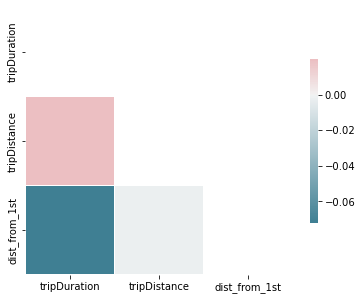

In [302]:
fig, ax = plt.subplots(figsize=(6, 6))

correlate = corr_map.corr()
# create a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.zeros_like(correlate, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlate, cmap=cmap, mask = mask, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [301]:
corr_map.corr()

,tripDuration,tripDistance,dist_from_1st
tripDuration,1.000000,0.019725,-0.071840
tripDistance,0.019725,1.000000,-0.002027
dist_from_1st,-0.071840,-0.002027,1.000000
